In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
# dataset.py

import torch
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class VehicleDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms

        self.image_filenames = []
        all_image_files = sorted(os.listdir(self.image_dir))
        
        # Pre-filter the list to ensure every image has a corresponding, non-empty label file
        for img_file in all_image_files:
            # Check if the file is an image (optional but good practice)
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            label_file = os.path.splitext(img_file)[0] + ".txt"
            label_path = os.path.join(self.label_dir, label_file)
            
            if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                self.image_filenames.append(img_file)
        
        if not self.image_filenames:
            raise ValueError(f"No valid image/label pairs found in {image_dir} and {label_dir}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        image = cv2.imread(img_path)
        img_height, img_width, _ = image.shape
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)
        
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5: # Safety check for malformed lines
                    continue
                class_id = int(float(parts[0]))
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])
                
                # De-normalize coordinates
                x_center = x_center_norm * img_width
                y_center = y_center_norm * img_height
                box_width = width_norm * img_width
                box_height = height_norm * img_height
                
                # Convert to [xmin, ymin, xmax, ymax]
                xmin = x_center - (box_width / 2)
                ymin = y_center - (box_height / 2)
                xmax = x_center + (box_width / 2)
                ymax = y_center + (box_height / 2)
                
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        # Create the dictionary to be passed to augmentations
        sample_to_transform = {
            'image': image,
            'bboxes': boxes,
            'labels': labels
        }
        
        if self.transforms:
            transformed_sample = self.transforms(**sample_to_transform)
            image = transformed_sample['image']
            
            # Use .get() to safely access keys that might be removed by transforms
            transformed_boxes = transformed_sample.get('bboxes', [])
            transformed_labels = transformed_sample.get('labels', [])
        else:
            # If no transforms, use original data
            transformed_boxes = boxes
            transformed_labels = labels

        # Create the final target dictionary for the model
        target = {}
        # Ensure boxes are FloatTensors and labels are LongTensors
        target['boxes'] = torch.as_tensor(transformed_boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(transformed_labels, dtype=torch.int64)
        
        # CRUCIAL: Handle the case where there are no boxes after augmentation
        if target['boxes'].shape[0] == 0:
            # The model expects a tensor of shape [0, 4] for empty boxes
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)

        return image, target

In [21]:
# transforms.py

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the training transforms
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # Note: ToTensorV2 will convert the image to a PyTorch tensor
        # and move the channel dimension to the first position (C, H, W)
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Define the validation transforms (no random augmentations)
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# In transforms.py
def get_train_transform():
    return A.Compose([
        # Geometric augmentations
        A.HorizontalFlip(p=0.5),
        # Randomly adjust scale, keeping aspect ratio. This is very effective.
        A.RandomScale(scale_limit=0.1, p=0.5), 
        # Randomly crop, ensuring a minimum part of the original image is visible.
        # You might need to adjust min_visibility for your box sizes.
        A.RandomCrop(width=512, height=512, p=0.1), 
        
        # Color augmentations
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
        A.RandomBrightnessContrast(p=0.5),

        # Always end with conversion to tensor
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_visibility': 0.3})

In [22]:
# model.py

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    """
    Creates a Faster R-CNN model with a ResNet-50 backbone.
    
    Args:
        num_classes (int): The number of classes for the model to predict,
                           including the background class.
                           
    Returns:
        A PyTorch model.
    """
    # 1. Load a pre-trained Faster R-CNN model
    # We use weights pre-trained on the COCO dataset, which is a great starting point.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
    
    # 2. Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # 3. Replace the pre-trained head with a new one
    # The new head will be tailored to our number of classes.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [23]:
# main.py

import torch
from torch.utils.data import DataLoader
#from dataset import VehicleDataset
#from transforms import get_train_transform, get_valid_transform
#from model import create_model  # Import our new function

# --- Hyperparameters and Configuration ---
TRAIN_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images'
TRAIN_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels'
VALID_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
VALID_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'

BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2 # 1 class (Vehicle) + 1 background

# --- Data Loading ---
def collate_fn(batch):
    return tuple(zip(*batch))

# Instantiate datasets
train_dataset = VehicleDataset(
    image_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LBL_DIR,
    transforms=get_train_transform()
)
valid_dataset = VehicleDataset(
    image_dir=VALID_IMG_DIR,
    label_dir=VALID_LBL_DIR,
    transforms=get_valid_transform()
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Device: {DEVICE}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

# --- Model Initialization ---
print("\n--- Initializing Model ---")
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
print("Model initialized and moved to device.")

# Let's inspect the model structure (optional)
#print(model)

# --- Test the DataLoader and Model ---
if __name__ == '__main__':
    print("\n--- Testing DataLoader and Model with a single batch ---")
    if len(train_loader) > 0:
        images, targets = next(iter(train_loader))
        
        # Move data to the correct device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        # Get model output (during training, the model returns losses)
        model.train() # Set the model to training mode
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        print(f"Successfully performed a forward pass.")
        print(f"Loss dictionary: {loss_dict}")
        print(f"Total loss for the batch: {losses.item()}")
    else:
        print("Training loader is empty. Check your data paths.")

Device: cuda
Number of training samples: 536
Number of validation samples: 90

--- Initializing Model ---
Model initialized and moved to device.

--- Testing DataLoader and Model with a single batch ---
Successfully performed a forward pass.
Loss dictionary: {'loss_classifier': tensor(0.6378, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.7307, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0878, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0372, device='cuda:0', grad_fn=<DivBackward0>)}
Total loss for the batch: 1.493630051612854


In [24]:
# engine.py

import torch
from tqdm import tqdm # A library for progress bars

def train_one_epoch(model, optimizer, data_loader, device):
    """
    Trains the model for one epoch.

    Args:
        model: The object detection model.
        optimizer: The optimizer.
        data_loader: The DataLoader for the training data.
        device: The device to train on ('cuda' or 'cpu').

    Returns:
        The average loss for the epoch.
    """
    model.train() # Set the model to training mode
    
    total_loss = 0
    progress_bar = tqdm(data_loader, desc="Training")

    for images, targets in progress_bar:
        # Move data to the correct device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # The model returns a dictionary of losses when in training mode
        loss_dict = model(images, targets)
        
        # Sum all the losses
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        total_loss += loss_value

        # Zero the gradients, perform backpropagation, and update the weights
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss_value)
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss

@torch.no_grad() # Disable gradient calculations for validation
def validate(model, data_loader, device, metric_calculator):
    """
    Validates the model on the validation set.

    Args:
        model: The object detection model.
        data_loader: The DataLoader for the validation data.
        device: The device to validate on.
        metric_calculator: The TorchMetrics object for calculating mAP.
    
    Returns:
        The calculated mAP score dictionary.
    """
    model.eval() # Set the model to evaluation mode
    metric_calculator.reset() # Reset metrics before new validation run
    
    progress_bar = tqdm(data_loader, desc="Validation")
    
    for images, targets in progress_bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Get model predictions
        outputs = model(images)

        # Update the metric calculator with the new predictions and targets
        metric_calculator.update(outputs, targets)
        
    # Compute the final metrics
    metrics = metric_calculator.compute()
    return metrics

In [25]:
# main.py

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import os

#from dataset import VehicleDataset
#from transforms import get_train_transform, get_valid_transform
#from model import create_model
#from engine import train_one_epoch, validate # Import the new functions

# --- Hyperparameters and Configuration ---
TRAIN_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/images'
TRAIN_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/train/labels'
VALID_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
VALID_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'

OUTPUT_DIR = '/kaggle/working/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

BATCH_SIZE = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2 # 1 class (Vehicle) + 1 background
NUM_EPOCHS = 25 # Start with 10 and increase if needed

# --- Data Loading ---
def collate_fn(batch):
    return tuple(zip(*batch))

# Instantiate datasets
train_dataset = VehicleDataset(
    image_dir=TRAIN_IMG_DIR,
    label_dir=TRAIN_LBL_DIR,
    transforms=get_train_transform()
)
valid_dataset = VehicleDataset(
    image_dir=VALID_IMG_DIR,
    label_dir=VALID_LBL_DIR,
    transforms=get_valid_transform()
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

print(f"Device: {DEVICE}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

# --- Model, Optimizer, and Metrics Initialization ---
print("\n--- Initializing Model ---")
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = optim.AdamW(params, lr=0.001, weight_decay=0.0001)

# # Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

optimizer = optim.AdamW(params, lr=0.0005, weight_decay=0.0001)
# Use CosineAnnealingLR for smoother learning rate decay
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)


# Metric Calculator
# We set `iou_type="bbox"` because we are evaluating bounding boxes.
# The class_metrics=True will give us per-class AP, recall, and precision.
map_metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True).to(DEVICE)


# --- The Main Training and Validation Loop ---
# In main.py

# ... (all the code above the loop remains the same) ...

# --- The Main Training and Validation Loop ---
# In main.py

# ... (all the code above the loop remains the same) ...

# --- The Main Training and Validation Loop ---
if __name__ == '__main__':
    best_map = 0.0 # To track the best performing model

    for epoch in range(NUM_EPOCHS):
        print(f"\n----- Epoch {epoch+1}/{NUM_EPOCHS} -----")
        
        # Train for one epoch
        train_loss = train_one_epoch(model, optimizer, train_loader, DEVICE)
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}")
        
        # Update the learning rate
        lr_scheduler.step()
        
        # Validate the model
        metrics = validate(model, valid_loader, DEVICE, map_metric)
        
        # --- CORRECTED METRIC ACCESS AND PRINTING ---
        print("\n--- Validation Metrics ---")
        
        map_val = metrics['map'].item()
        map_50_val = metrics['map_50'].item()
        mar_100_val = metrics['mar_100'].item()
        
        print(f"mAP @ .50:.95: {map_val:.4f}")
        print(f"mAP @ .50:     {map_50_val:.4f}")
        print(f"mAR @ .50:.95: {mar_100_val:.4f}")
        
        # --- ROBUST PER-CLASS METRIC HANDLING ---
        if 'map_per_class' in metrics and 'classes' in metrics:
            print("\n--- Per-Class AP @ .50:.95 ---")
            
            map_per_class = metrics['map_per_class']
            classes = metrics['classes']

            # Check if the tensors are 0-dimensional (scalar)
            if map_per_class.ndim == 0:
                # This handles the single-class case
                class_idx = classes.item()
                ap_val = map_per_class.item()
                print(f"  - Class {class_idx}: {ap_val:.4f}")
            else:
                # This handles the multi-class case
                for class_idx, ap_val in zip(classes, map_per_class):
                    print(f"  - Class {class_idx.item()}: {ap_val.item():.4f}")
        
        # Save the model if it has the best mAP so far
        if map_val > best_map:
            print(f"\nNew best model found! mAP improved from {best_map:.4f} to {map_val:.4f}")
            best_map = map_val
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
            print("Best model saved to outputs/best_model.pth")

    print("\n--- Training Complete ---")
    print(f"Final best validation mAP: {best_map:.4f}")

Device: cuda
Number of training samples: 536
Number of validation samples: 90

--- Initializing Model ---

----- Epoch 1/25 -----


Training: 100%|██████████| 134/134 [01:43<00:00,  1.30it/s, loss=0.472]


Epoch 1 Training Loss: 0.6471


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.5970
mAP @ .50:     0.9205
mAR @ .50:.95: 0.6814

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.5970

New best model found! mAP improved from 0.0000 to 0.5970
Best model saved to outputs/best_model.pth

----- Epoch 2/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.581]


Epoch 2 Training Loss: 0.4343


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.74it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6210
mAP @ .50:     0.9441
mAR @ .50:.95: 0.7006

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6210

New best model found! mAP improved from 0.5970 to 0.6210
Best model saved to outputs/best_model.pth

----- Epoch 3/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.277]


Epoch 3 Training Loss: 0.3929


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6163
mAP @ .50:     0.9398
mAR @ .50:.95: 0.6928

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6163

----- Epoch 4/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.439]


Epoch 4 Training Loss: 0.3704


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6530
mAP @ .50:     0.9481
mAR @ .50:.95: 0.7261

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6530

New best model found! mAP improved from 0.6210 to 0.6530
Best model saved to outputs/best_model.pth

----- Epoch 5/25 -----


Training: 100%|██████████| 134/134 [01:41<00:00,  1.31it/s, loss=0.38] 


Epoch 5 Training Loss: 0.3670


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6348
mAP @ .50:     0.9449
mAR @ .50:.95: 0.7139

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6348

----- Epoch 6/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.215]


Epoch 6 Training Loss: 0.3349


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6759
mAP @ .50:     0.9566
mAR @ .50:.95: 0.7408

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6759

New best model found! mAP improved from 0.6530 to 0.6759
Best model saved to outputs/best_model.pth

----- Epoch 7/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.363]


Epoch 7 Training Loss: 0.3045


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6585
mAP @ .50:     0.9581
mAR @ .50:.95: 0.7272

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6585

----- Epoch 8/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.369]


Epoch 8 Training Loss: 0.2942


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6570
mAP @ .50:     0.9585
mAR @ .50:.95: 0.7253

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6570

----- Epoch 9/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.39] 


Epoch 9 Training Loss: 0.2797


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6519
mAP @ .50:     0.9532
mAR @ .50:.95: 0.7220

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6519

----- Epoch 10/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.32] 


Epoch 10 Training Loss: 0.2785


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6717
mAP @ .50:     0.9611
mAR @ .50:.95: 0.7396

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6717

----- Epoch 11/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.214]


Epoch 11 Training Loss: 0.2598


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6720
mAP @ .50:     0.9640
mAR @ .50:.95: 0.7362

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6720

----- Epoch 12/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.219]


Epoch 12 Training Loss: 0.2395


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6714
mAP @ .50:     0.9596
mAR @ .50:.95: 0.7404

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6714

----- Epoch 13/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.195]


Epoch 13 Training Loss: 0.2264


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6501
mAP @ .50:     0.9572
mAR @ .50:.95: 0.7180

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6501

----- Epoch 14/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.199]


Epoch 14 Training Loss: 0.2131


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6717
mAP @ .50:     0.9641
mAR @ .50:.95: 0.7436

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6717

----- Epoch 15/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.207]


Epoch 15 Training Loss: 0.2008


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6797
mAP @ .50:     0.9660
mAR @ .50:.95: 0.7464

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6797

New best model found! mAP improved from 0.6759 to 0.6797
Best model saved to outputs/best_model.pth

----- Epoch 16/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.137] 


Epoch 16 Training Loss: 0.1799


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6749
mAP @ .50:     0.9569
mAR @ .50:.95: 0.7432

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6749

----- Epoch 17/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.253] 


Epoch 17 Training Loss: 0.1685


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6810
mAP @ .50:     0.9560
mAR @ .50:.95: 0.7463

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6810

New best model found! mAP improved from 0.6797 to 0.6810
Best model saved to outputs/best_model.pth

----- Epoch 18/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.147] 


Epoch 18 Training Loss: 0.1542


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6739
mAP @ .50:     0.9498
mAR @ .50:.95: 0.7432

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6739

----- Epoch 19/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.143] 


Epoch 19 Training Loss: 0.1429


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6693
mAP @ .50:     0.9328
mAR @ .50:.95: 0.7274

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6693

----- Epoch 20/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.192] 


Epoch 20 Training Loss: 0.1325


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6875
mAP @ .50:     0.9577
mAR @ .50:.95: 0.7507

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6875

New best model found! mAP improved from 0.6810 to 0.6875
Best model saved to outputs/best_model.pth

----- Epoch 21/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.144] 


Epoch 21 Training Loss: 0.1263


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6815
mAP @ .50:     0.9489
mAR @ .50:.95: 0.7474

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6815

----- Epoch 22/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.12]  


Epoch 22 Training Loss: 0.1205


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6790
mAP @ .50:     0.9468
mAR @ .50:.95: 0.7447

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6790

----- Epoch 23/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.0811]


Epoch 23 Training Loss: 0.1146


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6815
mAP @ .50:     0.9465
mAR @ .50:.95: 0.7462

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6815

----- Epoch 24/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.30it/s, loss=0.104] 


Epoch 24 Training Loss: 0.1123


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6773
mAP @ .50:     0.9471
mAR @ .50:.95: 0.7438

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6773

----- Epoch 25/25 -----


Training: 100%|██████████| 134/134 [01:42<00:00,  1.31it/s, loss=0.108] 


Epoch 25 Training Loss: 0.1110


Validation: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s]



--- Validation Metrics ---
mAP @ .50:.95: 0.6783
mAP @ .50:     0.9461
mAR @ .50:.95: 0.7460

--- Per-Class AP @ .50:.95 ---
  - Class 1: 0.6783

--- Training Complete ---
Final best validation mAP: 0.6875



--- Visualizing a batch of 8 images from the DataLoader ---


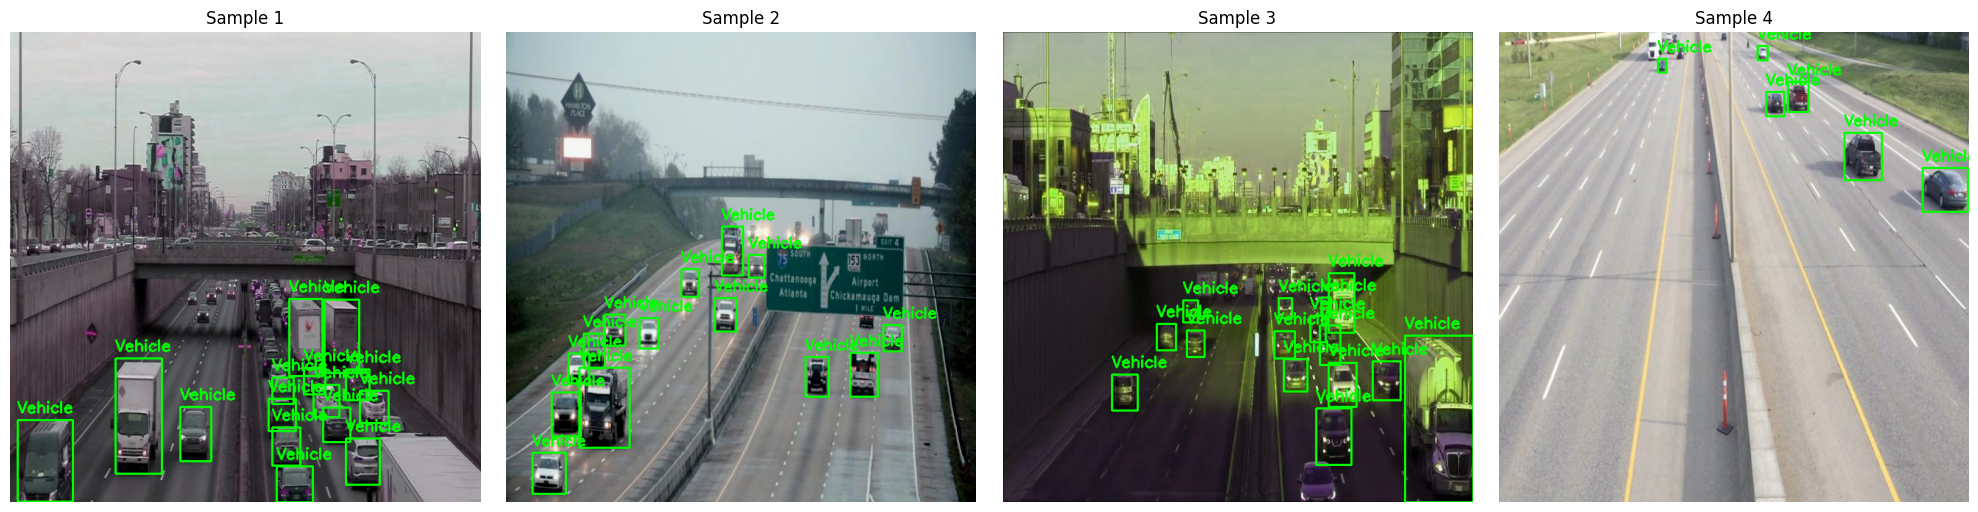

In [26]:
# utils.py

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the classes (we have only one)
# Background is class 0, Vehicle is class 1
CLASSES = [
    '__background__', 'Vehicle'
]

# Define a color for our bounding boxes
# We can add more colors if we add more classes
COLORS = [
    (0, 0, 0), # Background
    (0, 255, 0) # Green for Vehicle
]

def visualize_batch(images, targets, num_samples=10):
    """
    Visualizes a batch of images with their corresponding bounding boxes.
    
    Args:
        images: A list of image tensors.
        targets: A list of target dictionaries.
        num_samples: The number of samples to display from the batch.
    """
    # Make sure we don't try to plot more images than we have
    num_samples = min(num_samples, len(images))
    
    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    if num_samples == 1:
        axes = [axes] # Make it iterable if only one sample

    for i in range(num_samples):
        image_tensor = images[i]
        target = targets[i]

        # Convert tensor image to a NumPy array for OpenCV
        # Permute the dimensions from (C, H, W) to (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        
        # Denormalize the image (from [0,1] to [0,255]) and convert to uint8
        image_np = (image_np * 255).astype(np.uint8)
        
        # Create a writable copy for drawing
        image_to_draw = image_np.copy()
        
        boxes = target['boxes'].cpu().numpy().astype(np.int32)
        labels = target['labels'].cpu().numpy()

        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            class_name = CLASSES[label]
            color = COLORS[label]
            
            # Draw the bounding box
            cv2.rectangle(image_to_draw, (xmin, ymin), (xmax, ymax), color, 2)
            
            # Put the class name text above the box
            cv2.putText(image_to_draw, class_name, (xmin, ymin-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            
        axes[i].imshow(image_to_draw)
        axes[i].set_title(f'Sample {i+1}')
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- VISUALIZATION TEST ---
    print("\n--- Visualizing a batch of 8 images from the DataLoader ---")
    if len(train_loader) > 0:
        images, targets = next(iter(train_loader))
        # Call the visualization function for up to 8 samples
        visualize_batch(images, targets, num_samples=8)
    else:
        print("Training loader is empty. Cannot visualize.")



In [27]:
# In utils.py

# ... (keep the other functions and imports) ...

def calculate_iou(box1, box2):
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes.

    Args:
        box1 (list or tensor): [xmin, ymin, xmax, ymax]
        box2 (list or tensor): [xmin, ymin, xmax, ymax]

    Returns:
        float: The IoU value.
    """
    # Determine the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of intersection
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute the area of both bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute the area of the union
    union_area = box1_area + box2_area - intersection_area

    # Compute the IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

Loading model...
Model loaded.


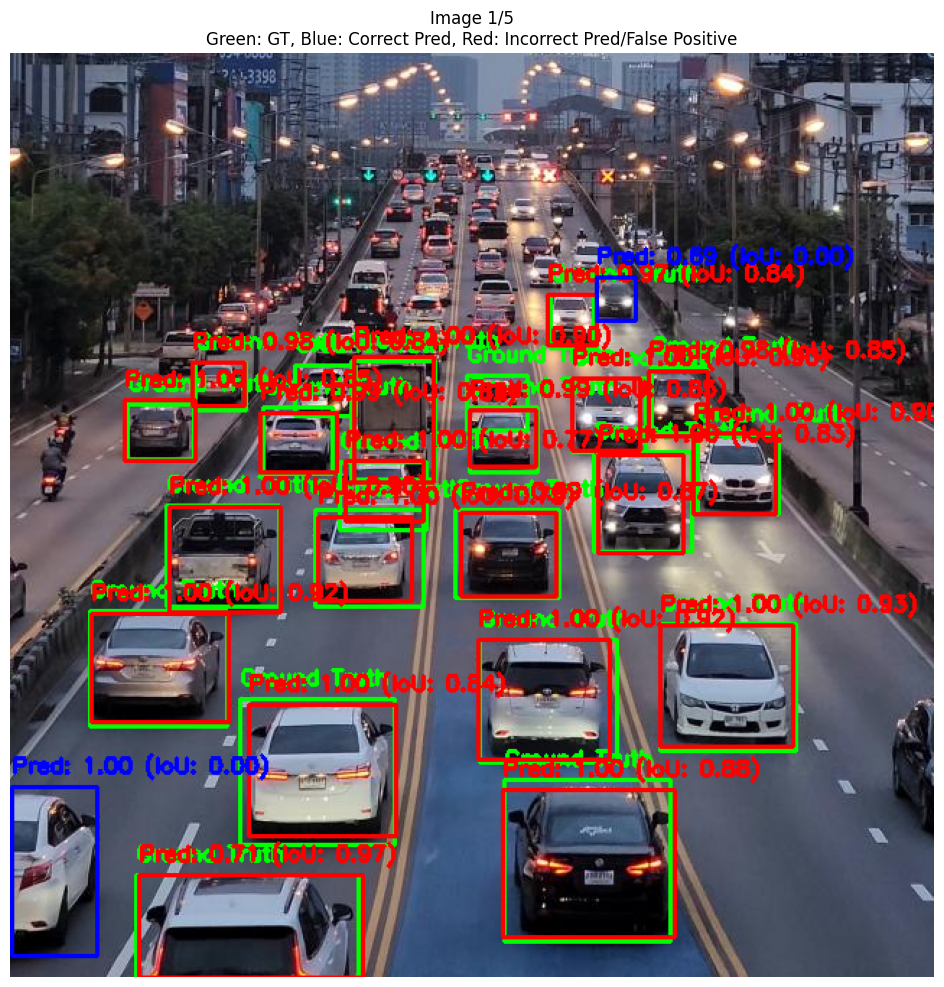

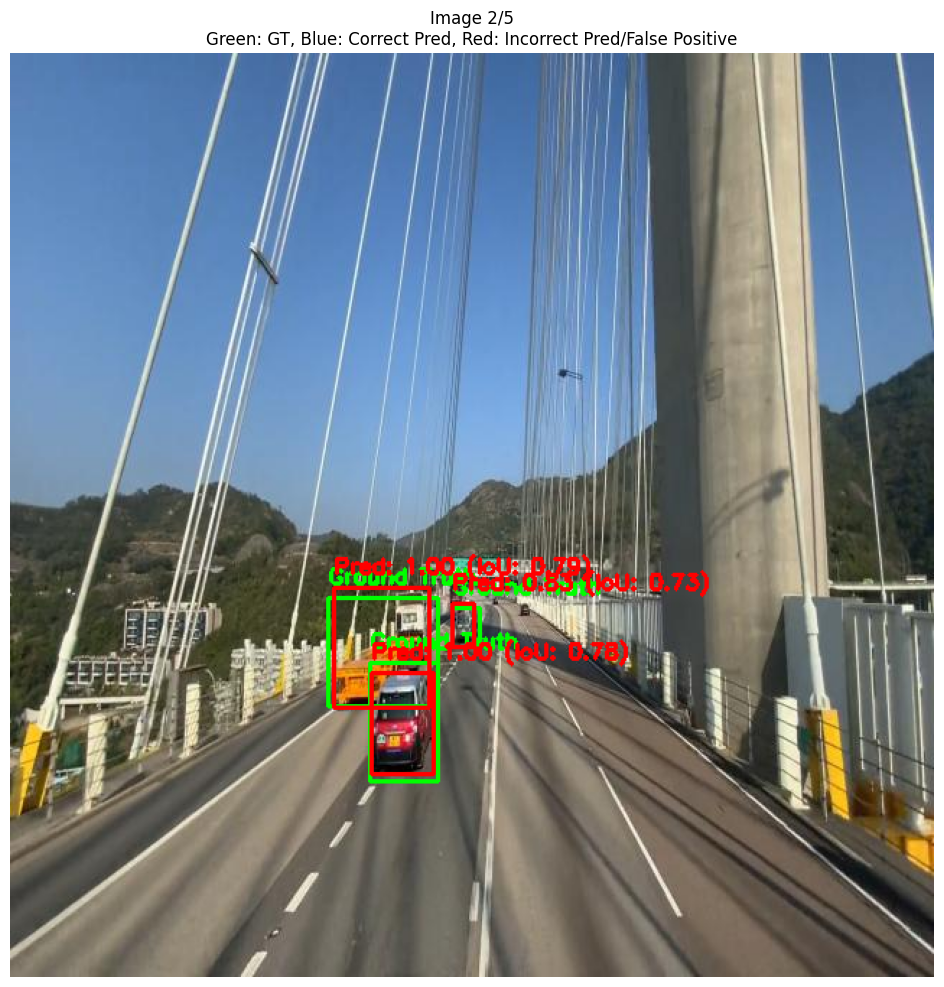

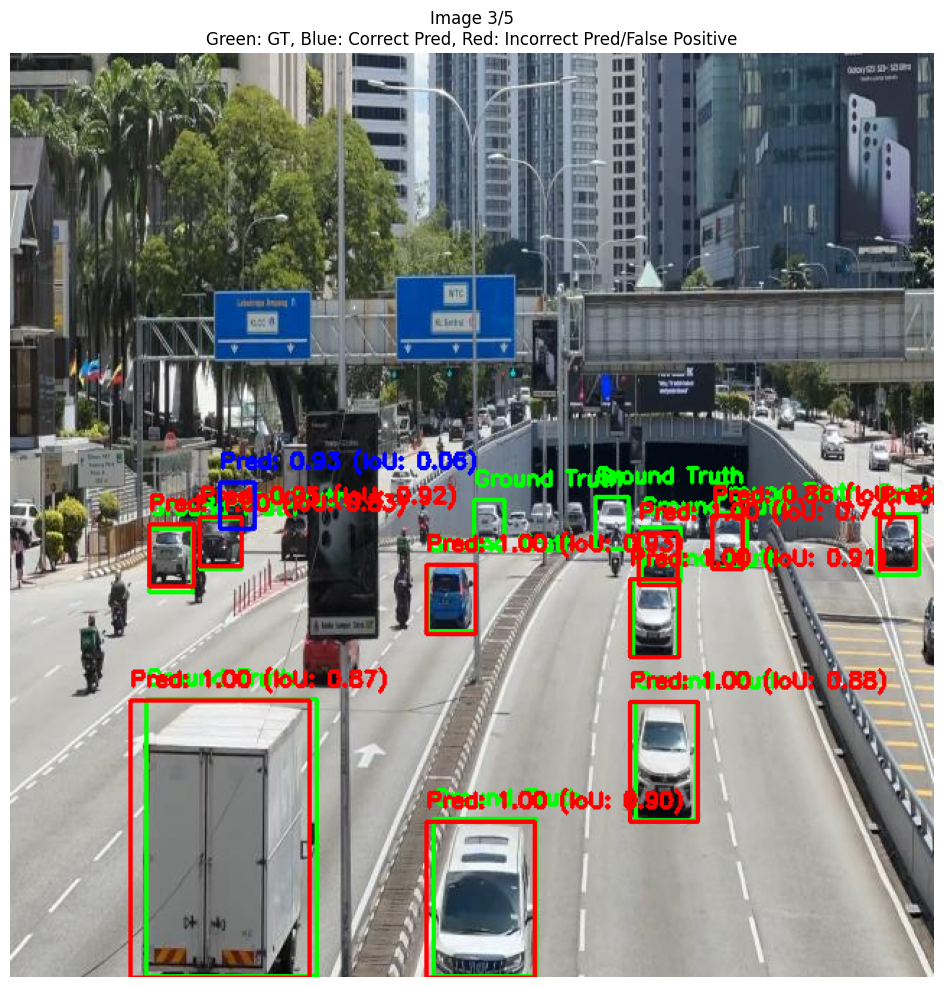

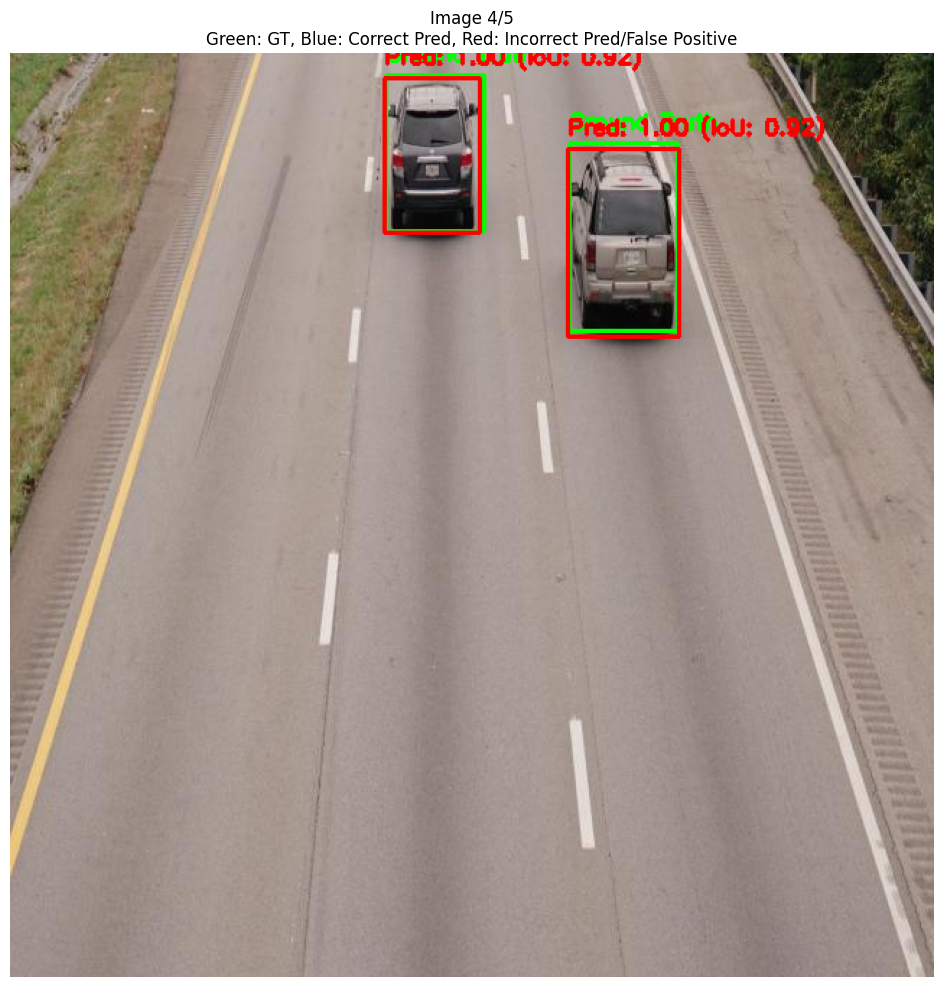

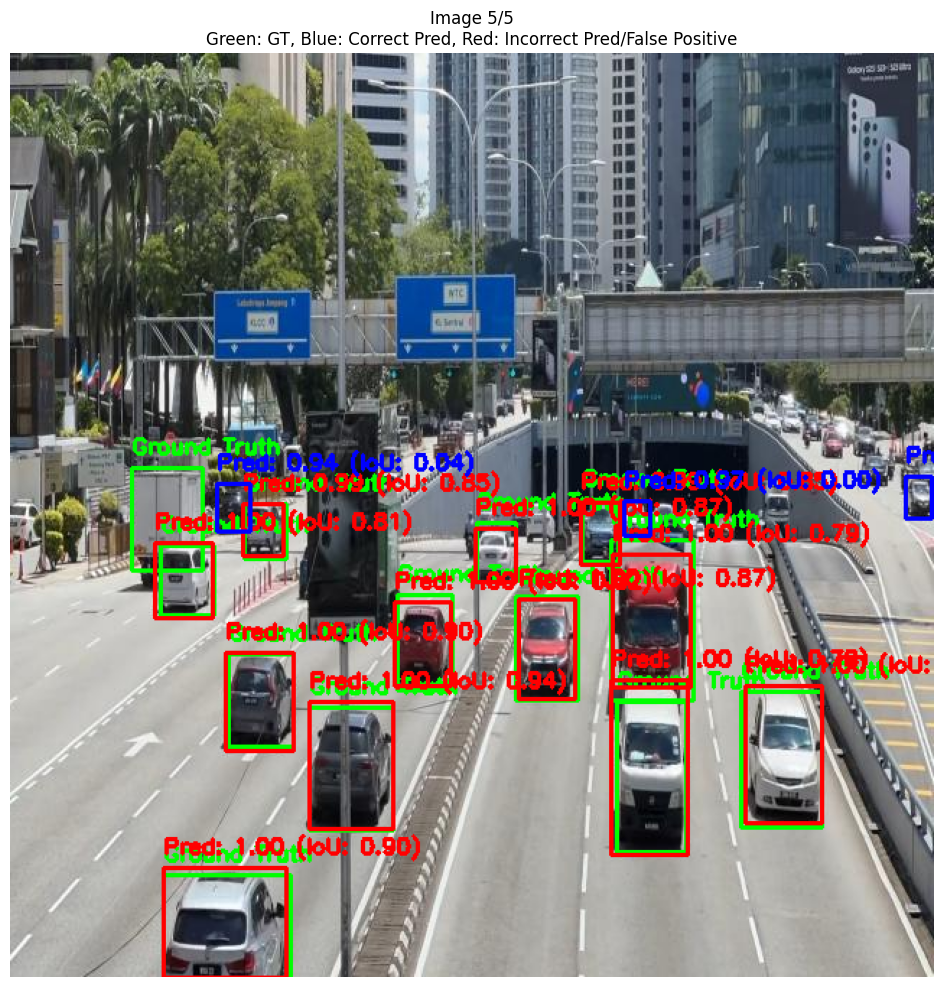

In [28]:
# visualize_results.py

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os # Added os import for path joining

# from dataset import VehicleDataset
# from transforms import get_valid_transform
# from model import create_model
# from utils import calculate_iou, collate_fn

# --- Configuration ---
DATA_IMG_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/images'
DATA_LBL_DIR = '/kaggle/input/traffic-dataset/traffic_wala_dataset/valid/labels'
MODEL_PATH = '/kaggle/working/best_model.pth'

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 2
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

GT_COLOR = (0, 255, 0)       # Green
PRED_CORRECT_COLOR = (255, 0, 0) # Blue
PRED_INCORRECT_COLOR = (0, 0, 255) # Red

# --- Main Evaluation and Visualization Function ---
def analyze_predictions(num_images_to_show=5): # Add a parameter for flexibility
    # Load dataset and dataloader
    dataset = VehicleDataset(
        image_dir=DATA_IMG_DIR,
        label_dir=DATA_LBL_DIR,
        transforms=get_valid_transform()
    )
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn) # Shuffle to see different images each time

    # Load model
    print("Loading model...")
    model = create_model(num_classes=NUM_CLASSES)
    
    # Ensure the model file exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file not found at {MODEL_PATH}")
        return
        
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded.")

    # --- MODIFICATION FOR 5 IMAGES ---
    images_shown = 0

    for images, targets in data_loader:
        if images_shown >= num_images_to_show:
            break

        image_tensor = images[0].to(DEVICE)
        target = targets[0]
        
        with torch.no_grad():
            output = model([image_tensor])[0]

        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        image_to_draw = (image_np * 255).astype(np.uint8).copy()

        # Draw Ground Truth Boxes
        gt_boxes = target['boxes'].cpu().numpy().astype(int)
        for box in gt_boxes:
            cv2.rectangle(image_to_draw, (box[0], box[1]), (box[2], box[3]), GT_COLOR, 2)
            cv2.putText(image_to_draw, 'Ground Truth', (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, GT_COLOR, 2)

        # Analyze and Draw Prediction Boxes
        pred_scores = output['scores'].cpu().numpy()
        pred_boxes = output['boxes'].cpu().numpy().astype(int)
        
        high_conf_indices = np.where(pred_scores >= CONFIDENCE_THRESHOLD)[0]
        
        for i in high_conf_indices:
            pred_box = pred_boxes[i]
            score = pred_scores[i]
            
            best_iou = 0
            if len(gt_boxes) > 0: # Only calculate IoU if there are ground truth boxes
                for gt_box in gt_boxes:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > best_iou:
                        best_iou = iou
            
            box_color = PRED_CORRECT_COLOR if best_iou >= IOU_THRESHOLD else PRED_INCORRECT_COLOR
            label_text = f"Pred: {score:.2f} (IoU: {best_iou:.2f})"
            
            cv2.rectangle(image_to_draw, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), box_color, 2)
            cv2.putText(image_to_draw, label_text, (pred_box[0], pred_box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
            
        # Display the image
        plt.figure(figsize=(12, 12))
        plt.imshow(image_to_draw)
        plt.title(f"Image {images_shown + 1}/{num_images_to_show}\nGreen: GT, Blue: Correct Pred, Red: Incorrect Pred/False Positive")
        plt.axis('off')
        plt.show()

        images_shown += 1 # Increment the counter

if __name__ == '__main__':
    analyze_predictions(num_images_to_show=5)

In [29]:
pip install deep-sort-realtime


Note: you may need to restart the kernel to use updated packages.


In [53]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort

# --- CONFIGURATION (UPDATED WITH YOUR PATHS) ---
VIDEO_PATH = "/kaggle/input/video-data/WhatsApp Video 2025-06-16 at 03.24.00.mp4"
MODEL_PATH = "/kaggle/working/best_model.pth"
OUTPUT_PATH = "/kaggle/working/tracked_video_output.mp4" # Corrected to be a full file path

# Model and Detection Config
NUM_CLASSES = 2      # IMPORTANT: Make sure this matches your model (e.g., 1 class 'vehicle' + 1 background = 2)
CONF_THRESH = 0.6    # Confidence threshold for detections
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tracking and Counting Config
ROI_LINE_Y = 0.6     # Y-coordinate for the counting line as a fraction of frame height (0.0 to 1.0)
PIXELS_PER_METER = 20 # IMPORTANT: Calibrate this value for your specific camera view for accurate speed

print(f"Using device: {DEVICE}")
print(f"Input Video: {VIDEO_PATH}")
print(f"Model: {MODEL_PATH}")
print(f"Output Video: {OUTPUT_PATH}")


# --- MODEL LOADING ---
def load_faster_rcnn_model(num_classes):
    """
    Loads a pre-trained Faster R-CNN model with a ResNet50 backbone
    and replaces the classifier head with a new one for the custom number of classes.
    """
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the trained weights from your best_model.pth
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

    return model.to(DEVICE).eval()

# --- MAIN SCRIPT ---
def main():
    # Load the model
    print("Loading model...")
    model = load_faster_rcnn_model(NUM_CLASSES)
    print("Model loaded successfully.")

    # Initialize video capture and writer
    print("Setting up video capture...")
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print(f"Error opening video file: {VIDEO_PATH}")
        return

    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))
    print(f"Video properties: {W}x{H} @ {FPS:.2f} FPS")

    # Initialize DeepSORT tracker
    tracker = DeepSort(max_age=30)

    # Define the counting line based on the ROI_LINE_Y fraction
    counting_line_y_pos = int(ROI_LINE_Y * H)

    # Data structures for counting and speed estimation
    entry_count = 0
    exit_count = 0
    object_last_centers = {} # {track_id: (cx, cy)}

    frame_count = 0
    print("\nStarting video processing...")
    # Main processing loop
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("\nVideo processing finished.")
            break
        
        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processing frame {frame_count}...")


        # Prepare frame for model (convert BGR to RGB, create tensor)
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = torchvision.transforms.functional.to_tensor(img_rgb).to(DEVICE).unsqueeze(0)

        # Get model predictions
        with torch.no_grad():
            predictions = model(img_tensor)[0]

        # Format detections for DeepSORT
        detections = []
        vehicle_class_id = 1 # Assuming your vehicle class is ID 1
        for box, score, label in zip(predictions["boxes"], predictions["scores"], predictions["labels"]):
            if score >= CONF_THRESH and label == vehicle_class_id:
                x1, y1, x2, y2 = map(int, box.tolist())
                w, h = x2 - x1, y2 - y1
                detections.append(([x1, y1, w, h], float(score), "vehicle"))

        # Update tracker with new detections
        tracks = tracker.update_tracks(detections, frame=frame)
        visible_vehicle_count = 0

        # Process each confirmed track
        for track in tracks:
            if not track.is_confirmed():
                continue
            visible_vehicle_count += 1

            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

            speed_mps = 0 # Speed in meters per second
            if track_id in object_last_centers:
                prev_cx, prev_cy = object_last_centers[track_id]

                # Directional Counting
                if prev_cy < counting_line_y_pos <= cy:
                    entry_count += 1
                elif prev_cy > counting_line_y_pos >= cy:
                    exit_count += 1

                # Speed Estimation
                dist_pixels = np.hypot(cx - prev_cx, cy - prev_cy)
                speed_mps = (dist_pixels * FPS) / PIXELS_PER_METER
            
            object_last_centers[track_id] = (cx, cy)

            # Visualization
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            label_text = f"ID:{track_id} {speed_mps:.1f} m/s"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # Draw UI Overlays
        cv2.line(frame, (0, counting_line_y_pos), (W, counting_line_y_pos), (255, 255, 0), 2)
        cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3)
        cv2.putText(frame, f"Vehicles in Frame: {visible_vehicle_count}", (20, 85),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

        # Write frame to output video
        out_vid.write(frame)

    # Cleanup
    cap.release()
    out_vid.release()
    cv2.destroyAllWindows()
    print(f"✅ Processing complete. Output video saved to: {OUTPUT_PATH}")

if __name__ == '__main__':
    main()

Using device: cuda
Input Video: /kaggle/input/video-data/WhatsApp Video 2025-06-16 at 03.24.00.mp4
Model: /kaggle/working/best_model.pth
Output Video: /kaggle/working/tracked_video_output.mp4
Loading model...
Model loaded successfully.
Setting up video capture...
Video properties: 960x540 @ 25.00 FPS

Starting video processing...
Processing frame 10...
Processing frame 20...
Processing frame 30...
Processing frame 40...
Processing frame 50...
Processing frame 60...
Processing frame 70...
Processing frame 80...
Processing frame 90...
Processing frame 100...
Processing frame 110...
Processing frame 120...
Processing frame 130...
Processing frame 140...
Processing frame 150...
Processing frame 160...
Processing frame 170...
Processing frame 180...
Processing frame 190...
Processing frame 200...
Processing frame 210...
Processing frame 220...
Processing frame 230...
Processing frame 240...
Processing frame 250...
Processing frame 260...
Processing frame 270...
Processing frame 280...
Proce

In [65]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from tqdm import tqdm # --- NEW: Import tqdm

# --- CONFIGURATION ---
VIDEO_PATH = "/kaggle/input/traffic-sample/sample_traffic.mp4"
MODEL_PATH = "/kaggle/working/best_model.pth"
OUTPUT_PATH = "/kaggle/working/density_counted_video.mp4"

# Model and Detection Config
NUM_CLASSES = 2
CONF_THRESH = 0.6
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Density Config
DENSITY_THRESHOLDS = {
    'HEAVY': 8,
    'MEDIUM': 6,
    'LIGHT':3
}

# Tracking and Counting Config
ROI_LINE_Y = 0.6
PIXELS_PER_METER = 20

print(f"Using device: {DEVICE}")

# --- MODEL LOADING (No changes here) ---
def load_faster_rcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    return model.to(DEVICE).eval()

# --- MAIN SCRIPT ---
def main():
    model = load_faster_rcnn_model(NUM_CLASSES)
    
    # 1. Initialize VideoCapture to create the 'cap' object
    cap = cv2.VideoCapture(VIDEO_PATH)
    if not cap.isOpened():
        print(f"Error: Could not open video file at {VIDEO_PATH}")
        return

    # 2. Get video properties now that 'cap' exists
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = cap.get(cv2.CAP_PROP_FPS)
    if FPS == 0: FPS = 30
    
    # --- NEW: Get total frame count for the progress bar ---
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_vid = cv2.VideoWriter(OUTPUT_PATH, fourcc, FPS, (W, H))

    tracker = DeepSort(max_age=30)
    entry_count = 0
    exit_count = 0
    object_last_centers = {}

    print("\nStarting video processing...")
    # --- MODIFIED: Replace the 'while' loop with a 'for' loop wrapped in tqdm ---
    for _ in tqdm(range(total_frames), desc="Analyzing Traffic Density"):
        ret, frame = cap.read()
        if not ret: break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = torchvision.transforms.functional.to_tensor(img_rgb).to(DEVICE).unsqueeze(0)

        with torch.no_grad():
            predictions = model(img_tensor)[0]

        detections = []
        for box, score, label in zip(predictions["boxes"], predictions["scores"], predictions["labels"]):
            if score >= CONF_THRESH and label == 1:
                x1, y1, x2, y2 = map(int, box.tolist())
                w, h = x2 - x1, y2 - y1
                detections.append(([x1, y1, w, h], float(score), "vehicle"))

        tracks = tracker.update_tracks(detections, frame=frame)
        visible_vehicle_count = 0

        for track in tracks:
            if not track.is_confirmed(): continue
            visible_vehicle_count += 1
            track_id = track.track_id
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            
            if track_id in object_last_centers:
                prev_cx, prev_cy = object_last_centers[track_id]
                if prev_cy < int(ROI_LINE_Y * H) <= cy: entry_count += 1
                elif prev_cy > int(ROI_LINE_Y * H) >= cy: exit_count += 1
            
            object_last_centers[track_id] = (cx, cy)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, f"ID:{track_id}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

        # Density classification logic
        if visible_vehicle_count > DENSITY_THRESHOLDS['HEAVY']:
            density_level, density_color = "HEAVY", (0, 0, 255)
        elif visible_vehicle_count > DENSITY_THRESHOLDS['MEDIUM']:
            density_level, density_color = "MEDIUM", (0, 255, 255)
        else:
            density_level, density_color = "LIGHT", (0, 255, 0)

        # Visualization
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (W, 100), (0, 0, 0), -1)
        frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
        cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Live Count: {visible_vehicle_count}", (20, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        density_text = f"Density: {density_level}"
        (w, h), _ = cv2.getTextSize(density_text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
        cv2.putText(frame, density_text, (W - w - 20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, density_color, 3)

        out_vid.write(frame)

    cap.release()
    out_vid.release()
    cv2.destroyAllWindows()
    # Add a newline to ensure the final message is on its own line after the progress bar
    print(f"\n✅ Processing complete with density analysis. Output video saved to: {OUTPUT_PATH}")

if __name__ == '__main__':
    main()

Using device: cuda

Starting video processing...


Analyzing Traffic Density: 100%|██████████| 1501/1501 [04:05<00:00,  6.12it/s]


✅ Processing complete with density analysis. Output video saved to: /kaggle/working/density_counted_video.mp4


In [30]:
# main.py (with stopped vehicle detection)

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from tqdm import tqdm
from collections import defaultdict, deque # NEW: Import deque
import time

# --- CONFIGURATION ---
class Config:
    VIDEO_PATH = "/kaggle/input/traffic-aims/traffic.mp4"
    MODEL_PATH = "/kaggle/working/best_model.pth"
    OUTPUT_PATH = "/kaggle/working/aims_test.mp4"
    
    # Model and Detection Config
    NUM_CLASSES = 2
    CONF_THRESH = 0.6
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Density Config
    DENSITY_THRESHOLDS = {
        'HEAVY': 8,
        'MEDIUM': 6,
        'LIGHT': 3
    }
    
    # --- NEW: Stopped Vehicle Detection Config ---
    # How many seconds a vehicle must be stationary to be flagged
    STOPPED_TIME_THRESH = 2.0 
    # How many pixels a vehicle can move and still be considered "stopped"
    STOPPED_PIXEL_THRESH = 5 
    
    # Tracking and Counting Config
    ROI_LINE_Y_PERCENT = 0.6 # Use a more descriptive name

print(f"Using device: {DEVICE}")

# --- MODEL LOADING ---
def load_faster_rcnn_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    return model.to(DEVICE).eval()

# --- MAIN SCRIPT ---
def main():
    config = Config()
    model = load_faster_rcnn_model(config.NUM_CLASSES)
    
    cap = cv2.VideoCapture(config.VIDEO_PATH)
    if not cap.isOpened():
        print(f"Error: Could not open video file at {config.VIDEO_PATH}")
        return

    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    FPS = cap.get(cv2.CAP_PROP_FPS)
    if FPS == 0: FPS = 30
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_vid = cv2.VideoWriter(config.OUTPUT_PATH, fourcc, FPS, (W, H))

    tracker = DeepSort(max_age=30)
    
    # --- MODIFIED: Enhanced data structures for tracking ---
    entry_count = 0
    exit_count = 0
    object_last_centers = {}
    # Use a deque to store the last N positions for each track ID
    track_positions = defaultdict(lambda: deque(maxlen=int(FPS * config.STOPPED_TIME_THRESH)))
    # Store the timestamp when a vehicle is first considered stopped
    stopped_timers = {} 

    print("\nStarting video processing...")
    for frame_idx in tqdm(range(total_frames), desc="Analyzing Traffic"):
        ret, frame = cap.read()
        if not ret: break

        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = torchvision.transforms.functional.to_tensor(img_rgb).to(config.DEVICE).unsqueeze(0)

        with torch.no_grad():
            predictions = model(img_tensor)[0]

        detections = []
        for box, score, label in zip(predictions["boxes"], predictions["scores"], predictions["labels"]):
            if score >= config.CONF_THRESH and label == 1:
                x1, y1, x2, y2 = map(int, box.tolist())
                w, h = x2 - x1, y2 - y1
                detections.append(([x1, y1, w, h], float(score), "vehicle"))

        tracks = tracker.update_tracks(detections, frame=frame)
        visible_vehicle_count = 0
        
        # --- NEW: Set to keep track of IDs seen in the current frame ---
        current_frame_track_ids = set()

        for track in tracks:
            if not track.is_confirmed(): continue
            
            visible_vehicle_count += 1
            track_id = track.track_id
            current_frame_track_ids.add(track_id) # Add to seen set
            
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            
            # Append current position to the history deque
            track_positions[track_id].append((cx, cy))
            
            # Line crossing logic (unchanged)
            roi_line_y_abs = int(config.ROI_LINE_Y_PERCENT * H)
            if track_id in object_last_centers:
                prev_cx, prev_cy = object_last_centers[track_id]
                if prev_cy < roi_line_y_abs <= cy: entry_count += 1
                elif prev_cy > roi_line_y_abs >= cy: exit_count += 1
            object_last_centers[track_id] = (cx, cy)

            # --- NEW: Stopped Vehicle Logic ---
            is_stopped = False
            # Check only if we have enough historical data
            if len(track_positions[track_id]) == track_positions[track_id].maxlen:
                # Calculate the displacement over the tracked period
                start_pos = track_positions[track_id][0]
                end_pos = track_positions[track_id][-1]
                displacement = np.linalg.norm(np.array(start_pos) - np.array(end_pos))
                
                if displacement < config.STOPPED_PIXEL_THRESH:
                    is_stopped = True
            
            # --- MODIFIED: Visualization Logic ---
            box_color = (0, 0, 255) # Default red for tracked vehicles
            
            if is_stopped:
                box_color = (255, 0, 255) # Magenta for stopped vehicles
                cv2.putText(frame, "STOPPED", (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, box_color, 2)
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), box_color, 2)
            cv2.putText(frame, f"ID:{track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)
            
        # --- NEW: Clean up timers for tracks that are no longer present ---
        # This prevents memory leaks for vehicles that have left the scene
        stopped_keys_to_del = [tid for tid in stopped_timers if tid not in current_frame_track_ids]
        for tid in stopped_keys_to_del:
            del stopped_timers[tid]

        # Density classification logic (unchanged)
        if visible_vehicle_count > config.DENSITY_THRESHOLDS['HEAVY']:
            density_level, density_color = "HEAVY", (0, 0, 255)
        elif visible_vehicle_count > config.DENSITY_THRESHOLDS['MEDIUM']:
            density_level, density_color = "MEDIUM", (0, 255, 255)
        else:
            density_level, density_color = "LIGHT", (0, 255, 0)

        # Dashboard visualization (unchanged)
        overlay = frame.copy()
        cv2.rectangle(overlay, (0, 0), (W, 100), (0, 0, 0), -1)
        frame = cv2.addWeighted(overlay, 0.6, frame, 0.4, 0)
        cv2.putText(frame, f"IN: {entry_count}  OUT: {exit_count}", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Live Count: {visible_vehicle_count}", (20, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        density_text = f"Density: {density_level}"
        (w_text, h_text), _ = cv2.getTextSize(density_text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
        cv2.putText(frame, density_text, (W - w_text - 20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, density_color, 3)

        out_vid.write(frame)

    cap.release()
    out_vid.release()
    cv2.destroyAllWindows()
    print(f"\n✅ Processing complete with density and stopped vehicle analysis. Output video saved to: {config.OUTPUT_PATH}")

if __name__ == '__main__':
    main()

Using device: cuda

Starting video processing...


Analyzing Traffic: 100%|██████████| 900/900 [03:17<00:00,  4.56it/s]


✅ Processing complete with density and stopped vehicle analysis. Output video saved to: /kaggle/working/aims_test.mp4
